In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sqlalchemy import create_engine
from config.settings import Settings
import os

settings = Settings()

# ===== 1) MariaDB 접속 정보 설정 =====
DB_USER = "brighter87"
DB_PASSWORD = settings.DB_PASSWORD
DB_NAME = "trading"

# 집에서 작업 시 활성화
# DB_HOST = 192.168.0.2
# engine = create_engine(
#     f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}?charset=utf8mb4"
# )

#카페에서 작업 시 활성화
DB_HOST = "localhost" 
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3307/{DB_NAME}?charset=utf8mb4"
)

# ===== 2) holdings 테이블에서 '가장 최근' 스냅샷 한 번만 가져오기 =====
with engine.connect() as conn:
    # 가장 최근 저장 시각 (created_at) 1개 가져오기
    latest_ts = pd.read_sql(
        "SELECT MAX(created_at) AS ts FROM holdings", conn
    )["ts"][0]

    print("가장 최근 스냅샷 시각:", latest_ts)

    # 그 시각에 해당하는 보유 종목들만 가져오기
    df = pd.read_sql(
        """
        SELECT stk_nm, evlt_amt, pl_rt
        FROM holdings
        WHERE created_at = %(ts)s
        ORDER BY evlt_amt DESC
        """,
        conn,
        params={"ts": latest_ts},
    )

# 숫자형으로 변환 (혹시 문자열이면)
df["pl_rt"] = pd.to_numeric(df["pl_rt"], errors="coerce")
df["evlt_amt"] = pd.to_numeric(df["evlt_amt"], errors="coerce")

# NaN(변환 실패) 제거
df = df.dropna(subset=["pl_rt", "evlt_amt"])

# ===== 3) 전체 포트 비중 계산 =====
total_value = df["evlt_amt"].sum()
df["weight"] = df["evlt_amt"] / total_value * 100  # %

가장 최근 스냅샷 시각: 2025-12-12 12:54:39


In [8]:
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

if not os.path.exists(font_path):
    raise FileNotFoundError("NanumGothic.ttf not found")

font_prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

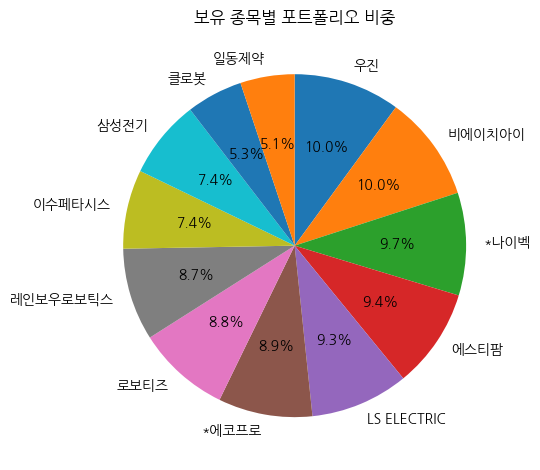

In [9]:
# 한글 폰트 설정 (시스템에 나눔고딕 등 설치되어 있다면)
plt.rcParams['font.family'] = 'NanumGothic'   # 또는 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지
plt.show()

# 상위 N개만 그리고 싶으면 df.head(N) 으로 바꾸셔도 됩니다.
labels = df["stk_nm"]
sizes = df["evlt_amt"]

# autopct 에서 실제 비중(%) 표시 => 전체 포트에서의 비중
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",        # 각 조각에 "xx.x%" 표시
    startangle=90,
    counterclock=False
)

plt.title("보유 종목별 포트폴리오 비중")
plt.tight_layout()
plt.show()


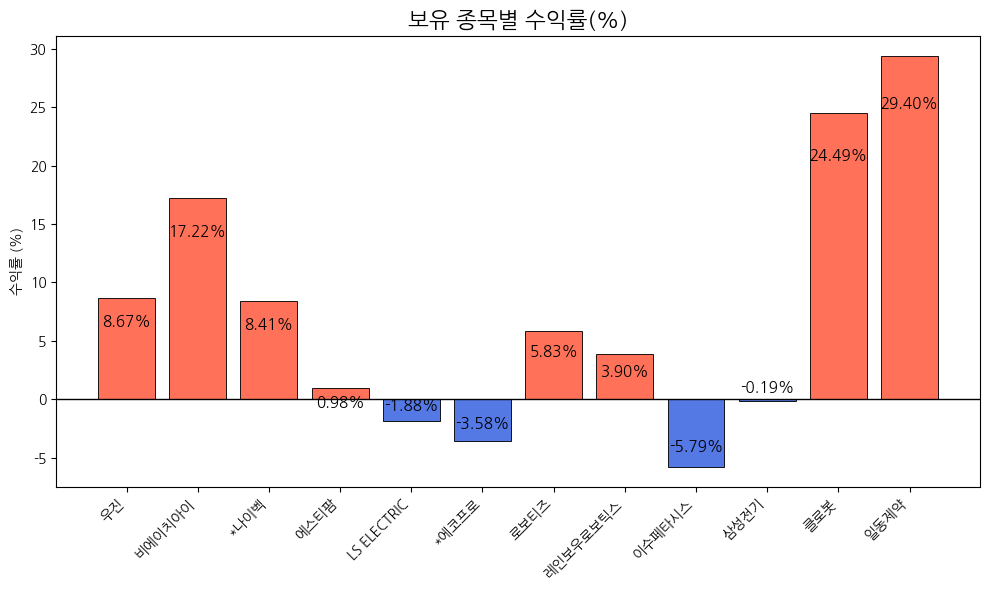

In [10]:
plt.figure(figsize=(10, 6))

# 색상 변경: 수익(+) = 빨간색 / 손실(-) = 파란색
colors = df["pl_rt"].apply(lambda x: "tomato" if x > 0 else "royalblue")

bars = plt.bar(
    df["stk_nm"],
    df["pl_rt"],
    color=colors,
    edgecolor="black",
    linewidth=0.7,
    alpha=0.9  # 살짝 입체감
)

plt.axhline(0, color="black", linewidth=1)
plt.title("보유 종목별 수익률(%)", fontsize=16)
plt.ylabel("수익률 (%)")
plt.xticks(rotation=45, ha="right")

# ----- 퍼센티지를 '막대 내부'에 표시 -----
for i, v in enumerate(df["pl_rt"]):
    if v >= 0:
        y = v - (abs(v) * 0.1 + 0.5)  # 막대 위쪽 내부
        va = "top"
    else:
        y = v + (abs(v) * 0.1 + 0.5)  # 막대 아래쪽 내부
        va = "bottom"

    plt.text(
        i,
        y,
        f"{v:.2f}%",
        ha="center",
        va=va,
        fontsize=11,
        color="black"          # 글씨색 모두 검정
    )

plt.tight_layout()
plt.show()


In [5]:
# today = datetime.now(kst).date()
target_date = "2025-12-11"

with engine.connect() as conn:
    df_trades = pd.read_sql(
        """
        SELECT
            query_date,
            stk_cd,
            stk_nm,
            cntr_qty,
            buy_uv,
            cntr_pric,
            tdy_sel_pl,
            pl_rt
        FROM realized_pnl_daily
        WHERE query_date = %(d)s
        ORDER BY stk_nm
        """,
        conn,
        params={"d": target_date},
    )

df_today = df_trades.copy()

df_today = df_today[[
    "query_date",
    "stk_nm",
    "buy_uv",
    "cntr_pric",
    "pl_rt",
]]

df_today.rename(columns={
    "query_date": "매도일",
    "stk_nm": "종목명",
    "buy_uv": "매수평균가",
    "cntr_pric": "매도가격",
    "pl_rt": "수익률(%)",
}, inplace=True)

In [6]:
def color_pnl(val):
    """수익률 색상: 플러스 빨강, 마이너스 파랑, 0은 회색"""
    try:
        v = float(val)
    except (TypeError, ValueError):
        return ""
    if v > 0:
        return "color: red; font-weight: bold;"
    elif v < 0:
        return "color: blue; font-weight: bold;"
    else:
        return "color: gray; font-weight: bold;"


styled = (
    df_today.style
        .format({
            "매수평균가": "{:,.0f}",
            "매도가격": "{:,.0f}",
            "수익률(%)": "{:.2f}",
        })
        .map(color_pnl, subset=["수익률(%)"])
        .hide(axis="index")  # 인덱스 제거
        .set_table_styles(
            [
                {"selector": "th", 
                 "props": [("font-weight", "bold"), ("background-color", "#f5f5f5")]},
                {"selector": "table",
                 "props": [("border-collapse", "collapse"), 
                           ("margin", "10px 0")]},
                {"selector": "td, th",
                 "props": [("border", "1px solid #ddd"), 
                           ("padding", "8px 12px"),
                           ("text-align", "center")]},
                {"selector": "tr:hover",
                 "props": [("background-color", "#fafafa")]}
            ]
        )
        .set_properties(**{
            "font-family": "NanumGothic",
            "font-size": "12pt"
        })
)

styled


매도일,종목명,매수평균가,매도가격,수익률(%)
2025-12-11,*에코프로비엠,"181,920","178,300",-2.20
2025-12-11,*에코프로비엠,"181,920","176,500",-3.19
2025-12-11,에코프로,"117,700","116,100",-1.54
2025-12-11,에코프로,"117,700","114,400",-2.98
2025-12-11,일동제약,"33,250","41,400",24.29
2025-12-11,코오롱인더,"46,850","46,050",-1.88
